# Sentiment analysis on IMDB large movie review dataset

Get the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/)

In [2]:
from glob import glob
import pandas as pd
import io
import numpy as np
import re
from IPython.display import SVG

from keras import models, layers
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import pickle

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
def parse_text(text):
    text = text.strip()
    # remove html
    text = re.sub(string=text, pattern=r"<[^>]*>", repl="")
    # add spaces between special characters
    text = re.sub(string=text,
                  pattern=r"([$&+,:;=?@#|\"<>.^*()%!-])",
                  repl=r" \1 ")
    return text

def read_and_append_files(folder, label):
    texts = []
    for file in glob('data/aclImdb/{0}/*.txt'.format(folder)):
        with open(file, 'r') as f:
            text = f.read()
            text = parse_text(text)
            texts.append((text, label))
            
    return texts

def make_df(pos, neg):
    df = pd.concat([pd.DataFrame(pos),
                    pd.DataFrame(neg)])\
           .sample(frac=1)\
           .reset_index(drop=True)
    df.columns = ['review', 'label']
    
    return df

In [3]:
train_pos = read_and_append_files('train/pos', 1)
train_neg = read_and_append_files('train/neg', 0)

test_pos = read_and_append_files('test/pos', 1)
test_neg = read_and_append_files('test/neg', 0)

In [4]:
train_df = make_df(train_pos, train_neg)
test_df = make_df(test_pos, test_neg)

In [5]:
train_df.head()

,review,label
0,Let me be clear . I've used IMDb for years . ...,0
1,"Though not a fan of Sam Rockwell , I was surp...",0
2,"OK , I have been a huge fan of the Black for ...",0
3,"What else can you say about this movie , excep...",0
4,"Yes , even as a fan of shows like survivor an...",0


In [6]:
test_df.head()

,review,label
0,The Merchant of Venice is a fantastic movie . ...,1
1,Film noir at its best . Set in the immediate ...,1
2,"Ah , another movie with motorcycles , hell's...",0
3,I have watched this movie quite bemused . I a...,0
4,I once had a conversation with my parents who ...,0


## Embeddings

I use [Fast Text pre trained embeddings](https://fasttext.cc/docs/en/english-vectors.html).

In [7]:
t = Tokenizer(lower=False, filters='\t\n')
t.fit_on_texts(train_df['review'])

In [47]:
def load_vectors(fname, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in word_index:
            w = word_index[tokens[0]]
            embedding_matrix[w] = np.fromiter(map(float, tokens[1:]), 'float')
    
    return embedding_matrix

In [48]:
%time vectors = load_vectors('data/wiki-news-300d-1M.vec', t.word_index)

CPU times: user 49.6 s, sys: 4.71 s, total: 54.3 s
Wall time: 1min 19s


In [49]:
vectors.shape

(113252, 300)

## Machine Learning with Keras

In [8]:
x_train = t.texts_to_matrix(train_df['review'])
y_train = train_df['label']

x_test = t.texts_to_matrix(test_df['review'])
y_test = test_df['label']

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 113252), (25000,), (25000, 113252), (25000,))

### Logistic regression

In [10]:
i = layers.Input(shape=(x_train.shape[1],))
h = layers.Dense(units=1, activation='sigmoid')(i)
model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['binary_accuracy'])

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [21]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 102s 4ms/step - loss: 0.4656 - binary_accuracy: 0.8327 - val_loss: 0.4472 - val_binary_accuracy: 0.8328


### Averaging Embeddings

In [44]:
x_train = pad_sequences(t.texts_to_sequences(train_df['review']), maxlen=1000)
y_train = train_df['label']

x_test = pad_sequences(t.texts_to_sequences(test_df['review']), maxlen=1000)
y_test = test_df['label']

In [45]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 1000), (25000,), (25000, 1000), (25000,))

In [ ]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

h = embedding_layer(i)
h = layers.Lambda(lambda r: K.mean(r, axis=1))(h)
h = layers.Dense(128, activation='relu')(h)
h = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

### Embeddings and GRU

In [ ]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

h = embedding_layer(i)
h = layers.GRU(128)(h)
h = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

### Embeddings and CNN

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


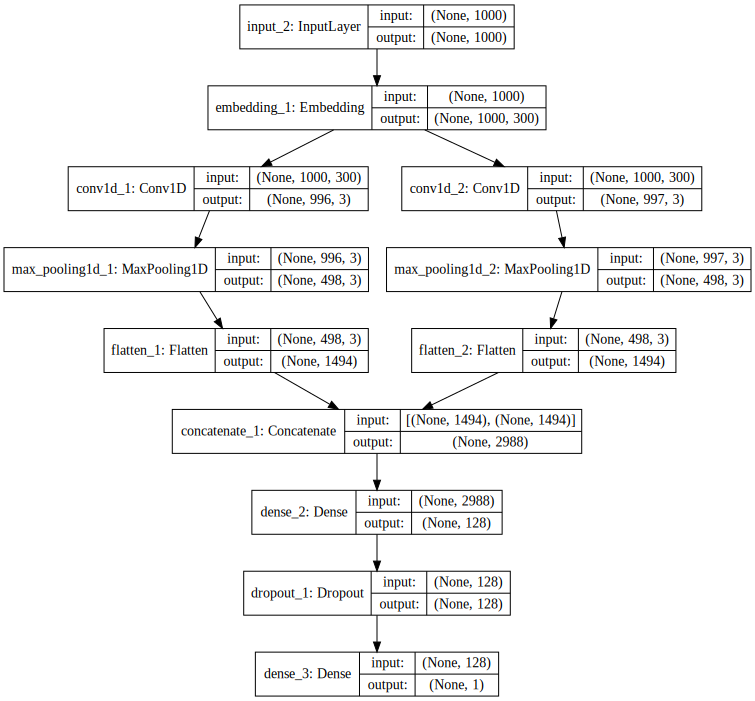

In [50]:
embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

i = layers.Input(shape=(x_train.shape[1],))
text_embedding = embedding_layer(i)
convs = []

for layer_params in [(3, 5), (3, 4)]:
    conv = layers.Conv1D(filters=layer_params[0],
                         kernel_size=layer_params[1],
                         activation='relu')(text_embedding)
    conv = layers.MaxPooling1D(pool_size=2)(conv)
    conv = layers.Flatten()(conv)
    convs.append(conv)

concat = layers.concatenate(convs)
hidden = layers.Dense(128, activation='relu')(concat)
hidden = layers.Dropout(0.3)(hidden)
output = layers.Dense(1, activation='sigmoid')(hidden)

model = models.Model(inputs=[i], outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [52]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 616s 25ms/step - loss: 0.4065 - binary_accuracy: 0.8036 - val_loss: 0.3003 - val_binary_accuracy: 0.8756
Epoch 2/2
25000/25000 [==============================] - 727s 29ms/step - loss: 0.2808 - binary_accuracy: 0.8864 - val_loss: 0.3058 - val_binary_accuracy: 0.8702


In [64]:
model.predict(pad_sequences(t.texts_to_sequences(["love is great !"]), 1000))

array([[0.7830022]], dtype=float32)

## Load exisiting

In [3]:
model = load_model("bin/CNN_model.pkl")

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [4]:
with open(os.path.join("bin", "{0}_tokenizer.pkl".format("CNN")), "rb") as f:
    tokenizer = pickle.load(f)

In [11]:
model.predict(pad_sequences(tokenizer.texts_to_sequences(["love"]), maxlen=1000))

array([[0.43474415, 0.5652558 ]], dtype=float32)